# Predicting the risk for heart disease with a classification model


This notebook is part of my **MLzoomcamp Midterm Project**. It includes ...

In [1]:
# importing libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sweetviz as sv
import sys

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    matthews_corrcoef,
    precision_score, 
    recall_score, 
    roc_auc_score,
    roc_curve,
    ConfusionMatrixDisplay, 
    confusion_matrix
)
from pandas import option_context

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, plot_importance

# importing user defined funtions
sys.path.append("../src")
from modeling import get_metrics, plot_cf_matrix, train_and_evaluate_models, plot_feature_importances

In [2]:
# allow showing more rows and columns when using the method df.head()
pd.set_option("display.max_columns", 100)

# Data loading

In [3]:
df = pd.read_csv('../data/heart_2020_cleaned_preproc_ordinal.csv')

In [4]:
df.head(3)

,heart_disease,bmi,smoking,alcohol_drinking,stroke,physical_health,mental_health,diff_walking,sex,age_category,race,diabetic,physical_activity,gen_health,sleep_time,asthma,kidney_disease,skin_cancer
0,0,16.60,1,0,0,3,30,0,female,7,white,yes,1,3,5,1,0,1
1,0,20.34,0,0,1,0,0,0,female,12,white,no,1,3,7,0,0,0
2,0,26.58,1,0,0,20,30,0,male,9,white,yes,1,1,8,1,0,0


# Data splitting

The data will be splitted in three partitions (40% / 20% / 20%) corresponding to train, test and validation sets. Since the data is imbalanced the splitting will be done setting the parameter `stratify` that allows keeping the proportion of classes in the different partitions.

In [5]:
# separating features and target
X = df.drop('heart_disease', axis=1)
y = df['heart_disease']

# data splitting
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full)

print(f'Train features shape       : {X_train.shape}')
print(f'Train target shape         : {y_train.shape}')
print(f'Validation features shape  : {X_val.shape}')
print(f'Validation target shape    : {y_val.shape}')
print(f'Test features shape        : {X_test.shape}')
print(f'Test target shape          : {y_test.shape}')

Train features shape       : (181029, 17)
Train target shape         : (181029,)
Validation features shape  : (60344, 17)
Validation target shape    : (60344,)
Test features shape        : (60344, 17)
Test target shape          : (60344,)


# One-hot encoding

Features:
* `diabetic`, `race`, `sex` 

In [6]:
# create a data dictionary of features

features = [
    'bmi',
    'smoking',
    'alcohol_drinking',
    'stroke',
    'physical_health',
    'mental_health',
    'diff_walking',
    'sex',
    'age_category',
    'race',
    'diabetic',
    'physical_activity',
    'gen_health',
    'sleep_time',
    'asthma',
    'kidney_disease',
    'skin_cancer'
]

train_dict = X_train[features].to_dict(orient='records')
val_dict = X_val[features].to_dict(orient='records')

# encode dictionary of features
dv = DictVectorizer(sparse=False)
X_train_dv = dv.fit_transform(train_dict)
X_val_dv = dv.transform(val_dict)

In [7]:
list(dv.get_feature_names_out())

['age_category',
 'alcohol_drinking',
 'asthma',
 'bmi',
 'diabetic=no',
 'diabetic=no, borderline diabetes',
 'diabetic=yes',
 'diabetic=yes (during pregnancy)',
 'diff_walking',
 'gen_health',
 'kidney_disease',
 'mental_health',
 'physical_activity',
 'physical_health',
 'race=american indian/alaskan native',
 'race=asian',
 'race=black',
 'race=hispanic',
 'race=other',
 'race=white',
 'sex=female',
 'sex=male',
 'skin_cancer',
 'sleep_time',
 'smoking',
 'stroke']

# Model building: imbalanced data

In [8]:
# model definitions
models = [
        KNeighborsClassifier(n_jobs=-1),
        LogisticRegression(random_state=42, max_iter=1500),
        DecisionTreeClassifier(random_state=42),
        RandomForestClassifier(random_state=42, n_jobs=-1),
        XGBClassifier(random_state=42, n_jobs=-1),
        GaussianNB(),
        ComplementNB(),
    ]

model_names = [
    "K-Nearest Neighbors",
    "Logistic Regression",
    "Decision Tree",
    "Random Forest",
    "XGBoost",
    "Gaussian NB",
    "Complement NB",
]

------------------------------------------------------------------------------------------
                                   Score Table                                   
------------------------------------------------------------------------------------------
 Modeling Algorithm  Accuracy  F1 Score  Precision  Recall  Specificity  MCC  ROC/AUC
K-Nearest Neighbors      0.90      0.14       0.33    0.09         0.98 0.13     0.54
Logistic Regression      0.91      0.18       0.54    0.11         0.99 0.22     0.55
      Random Forest      0.90      0.18       0.35    0.12         0.98 0.16     0.55
            XGBoost      0.91      0.18       0.55    0.11         0.99 0.21     0.55
      Decision Tree      0.85      0.24       0.23    0.25         0.91 0.16     0.58
      Complement NB      0.81      0.28       0.21    0.40         0.85 0.19     0.63
        Gaussian NB      0.80      0.34       0.25    0.57         0.83 0.28     0.70
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

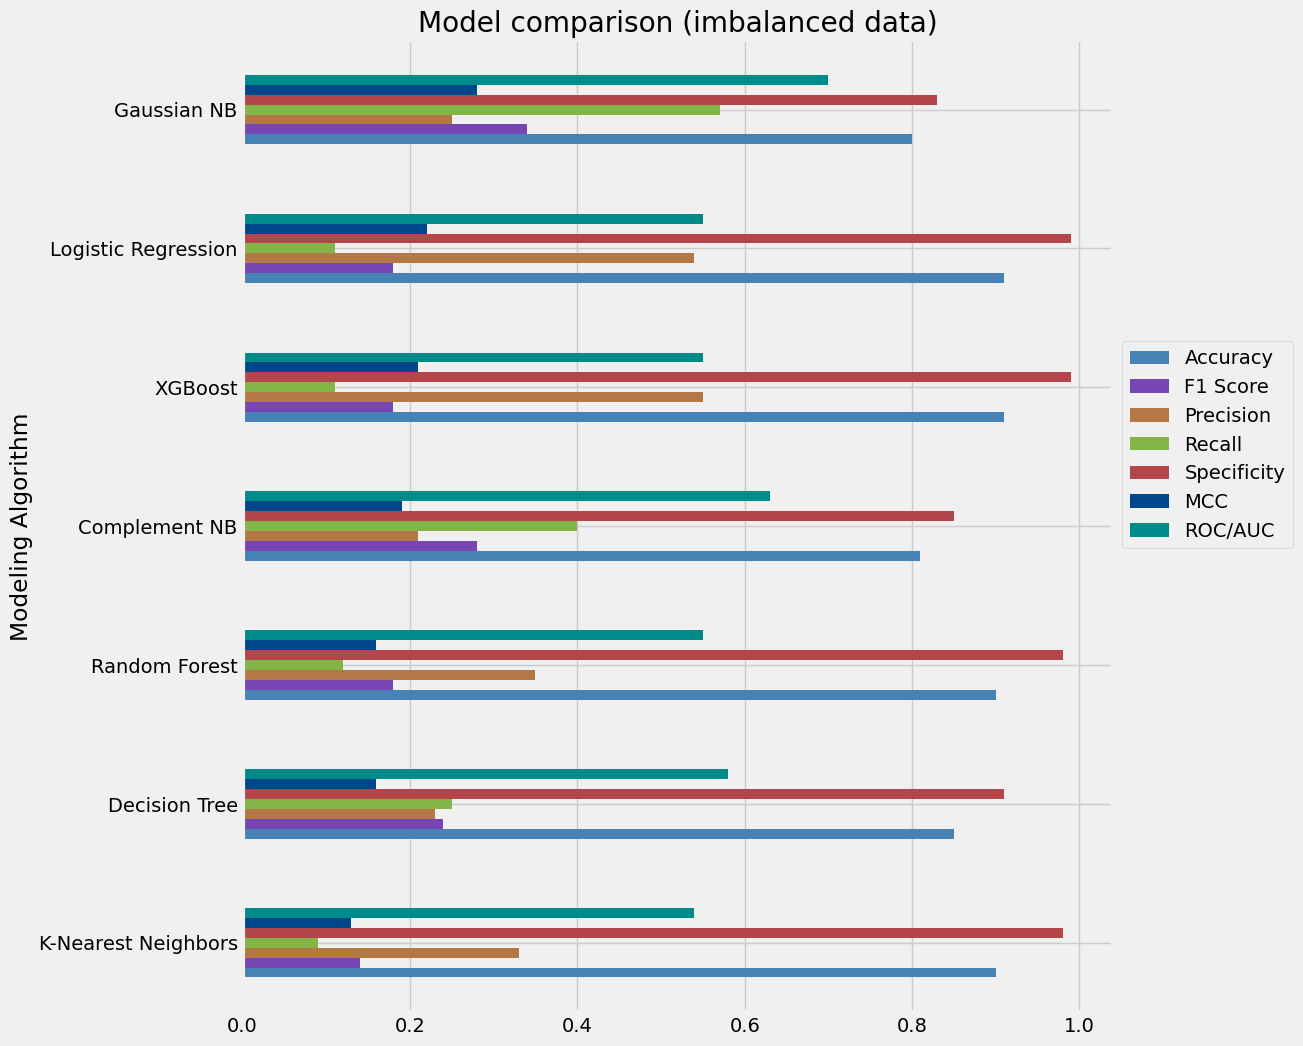

In [9]:
# training and evaluating the models
train_and_evaluate_models(
    X_train_dv, y_train, X_val_dv, y_val, 
    models=models,
    model_names=model_names,
    plot_title="Model comparison (imbalanced data)")

# Model building: handling class imbalance with class weight

In [10]:
# xgboost
negative_examples = y_train.value_counts()[0]
positive_examples = y_train.value_counts()[1]

scale_pos_weight = negative_examples/positive_examples
scale_pos_weight

10.067371767439017

In [11]:
# model definitions

models = [
    KNeighborsClassifier(n_jobs=-1),
    LogisticRegression(class_weight='balanced', random_state=42, max_iter=1500),
    DecisionTreeClassifier(class_weight='balanced', random_state=42),
    RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, n_jobs=-1),
    GaussianNB(priors=[0.91, 0.09]),
    ComplementNB(),
]

model_names = [
    "K-Nearest Neighbors",
    "Logistic Regression",
    "Decision Tree",
    "Random Forest",
    "XGBoost",
    "Gaussian NB",
    "Complement NB",
]

------------------------------------------------------------------------------------------
                                   Score Table                                   
------------------------------------------------------------------------------------------
 Modeling Algorithm  Accuracy  F1 Score  Precision  Recall  Specificity  MCC  ROC/AUC
K-Nearest Neighbors      0.90      0.14       0.33    0.09         0.98 0.13     0.54
      Random Forest      0.90      0.16       0.34    0.11         0.98 0.15     0.54
      Decision Tree      0.86      0.22       0.22    0.21         0.92 0.14     0.57
      Complement NB      0.81      0.28       0.21    0.40         0.85 0.19     0.63
        Gaussian NB      0.80      0.34       0.25    0.57         0.83 0.28     0.70
Logistic Regression      0.74      0.35       0.23    0.78         0.74 0.32     0.76
            XGBoost      0.74      0.35       0.23    0.76         0.74 0.31     0.75
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

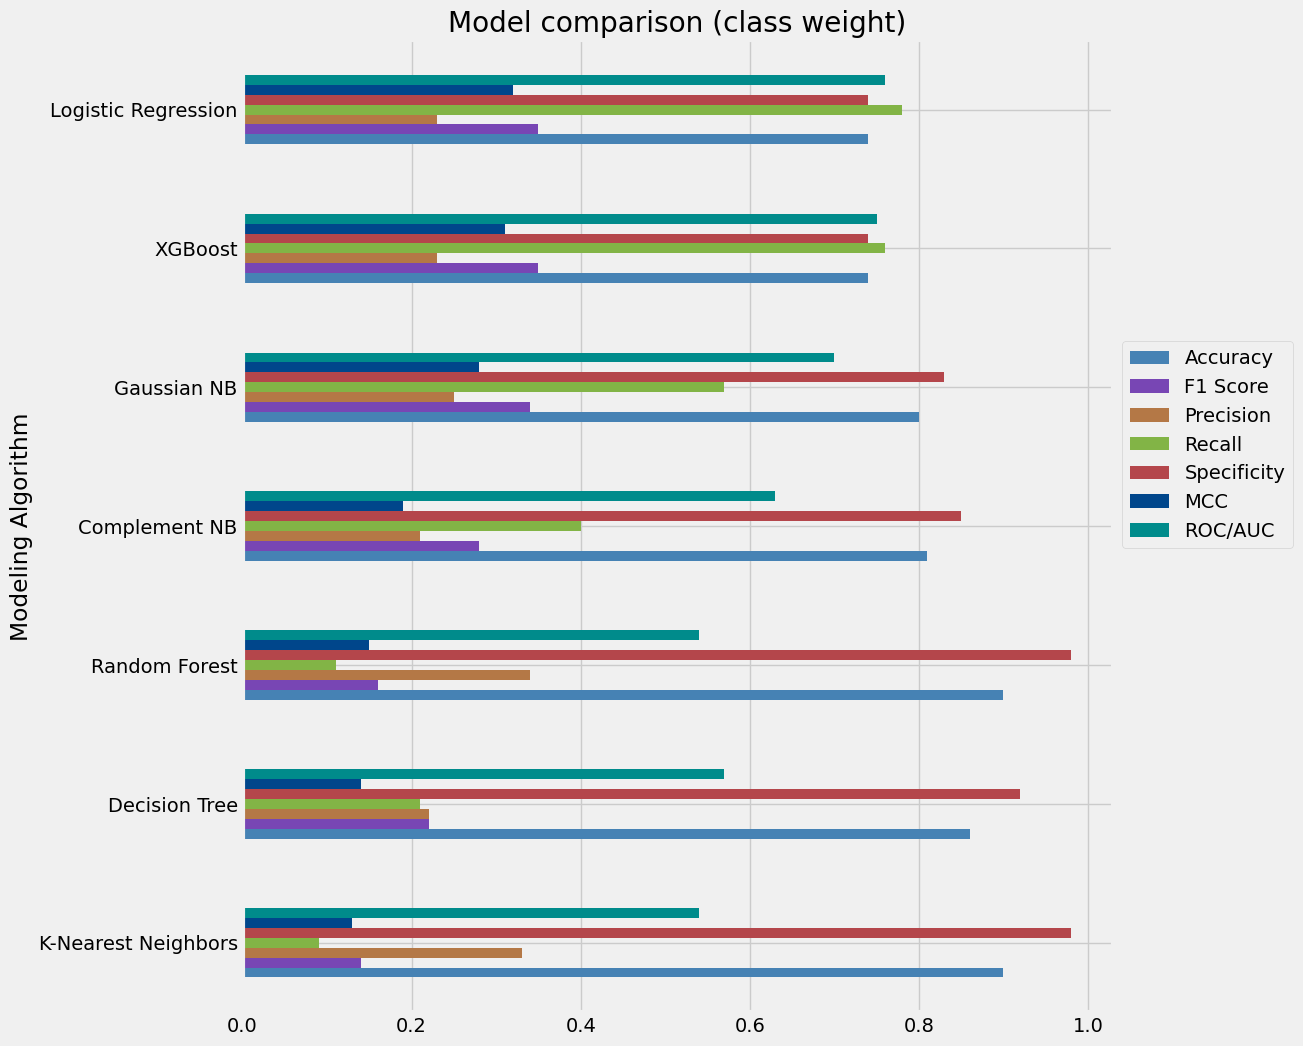

In [12]:
# training and evaluating the models
train_and_evaluate_models(
    X_train_dv, y_train, X_val_dv, y_val, 
    models=models,
    model_names=model_names,
    plot_title="Model comparison (class weight)")

## Notes

* In general, handling class imbalance with class weights improved models performance. Other techniques as oversampling and/or undersampling could be also applied to tackle this problem but we won't do this here. 
* Since we have an imbalanced classification problem the most useful metrics are F1 ,recall and MCC. The Matthews correlation coefficient (MCC) is a common metrics in imbalanced and medical problems.
* The best results were obtained for LogisticRegression and XGBoost.Their results are repeated bellow.
* XGBoost is the chosen method for tuning.

## Logistic regression

In [13]:
model_lr = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1500)
model_lr.fit(X_train_dv, y_train)
y_pred_lr = model_lr.predict(X_val_dv)

get_metrics(y_pred_lr, y_val)

-------------------------
         METRICS         
-------------------------
Accuracy       =   0.7431
F1 Score       =   0.3545
MCC            =   0.3231
Precision      =   0.2293
Recall         =   0.7808
ROC/AUC        =   0.7601
Specificity    =   0.7393
-.-.-.-.-.-.-.-.-.-.-.-.


In [14]:
confusion_matrix(y_val, y_pred_lr, normalize='true')

array([[0.73934271, 0.26065729],
       [0.21918562, 0.78081438]])

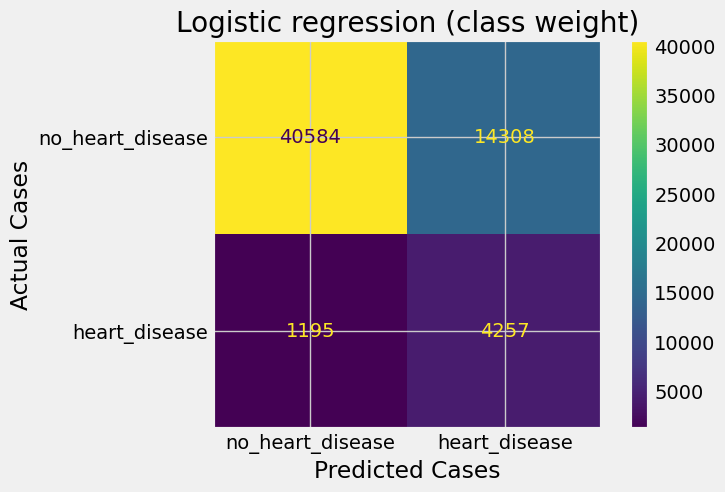

In [15]:
plot_cf_matrix(y_pred_lr, y_val, 'Logistic regression (class weight)')

## XGBoost

In [16]:
model_xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, n_jobs=-1)
model_xgb.fit(X_train_dv, y_train)
y_pred_xgb = model_xgb.predict(X_val_dv)

get_metrics(y_pred_xgb, y_val)

-------------------------
         METRICS         
-------------------------
Accuracy       =   0.7421
F1 Score       =   0.3481
MCC            =   0.3126
Precision      =   0.2255
Recall         =   0.7619
ROC/AUC        =   0.751 
Specificity    =   0.7401
-.-.-.-.-.-.-.-.-.-.-.-.


In [17]:
confusion_matrix(y_val, y_pred_xgb, normalize='true')

array([[0.74014428, 0.25985572],
       [0.23807777, 0.76192223]])

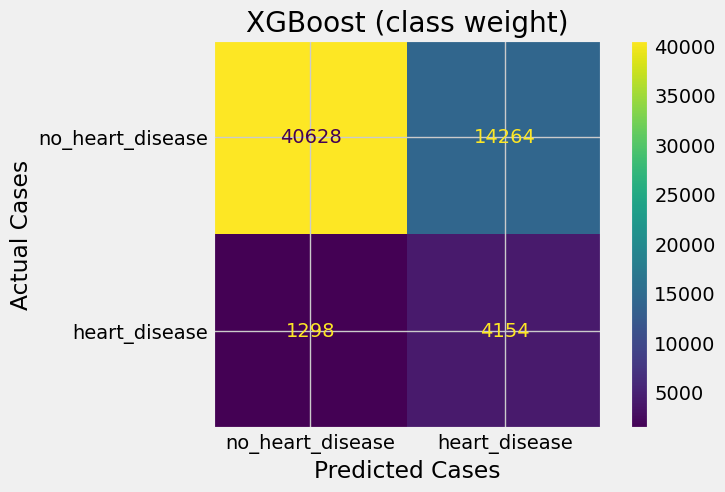

In [18]:
plot_cf_matrix(y_pred_xgb, y_val, 'XGBoost (class weight)')

## ROC-AUC (Logistic Regression and XGBoost)

No Skill: ROC AUC=0.500
Logistic Regression: ROC AUC=0.834
XGBoost: ROC AUC=0.827


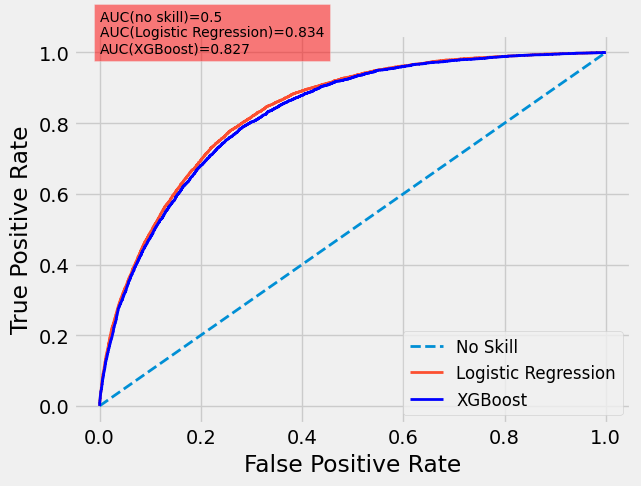

In [19]:
#
#fpr, tpr, thresholds = roc_curve(y_val, y_pred)

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_val))]
# predict probabilities
lr_probs = model_lr.predict_proba(X_val_dv)
xgb_probs = model_xgb.predict_proba(X_val_dv)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
xgb_probs = xgb_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_val, ns_probs)
lr_auc = roc_auc_score(y_val, lr_probs)
# lr_thres = roc_auc_score(y_val, y_pred)
xgb_auc = roc_auc_score(y_val, xgb_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic Regression: ROC AUC=%.3f' % (lr_auc))
# print('Logistic Regression Thresholded: ROC AUC=%.3f' % (lr_thres))
print('XGBoost: ROC AUC=%.3f' % (xgb_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_val, lr_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_val, xgb_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', linewidth=2, label='No Skill')
plt.plot(lr_fpr, lr_tpr, linewidth=2, label='Logistic Regression')
plt.plot(xgb_fpr, xgb_tpr, linewidth=2, label='XGBoost', color='b')
# plt.plot(fpr, tpr, linewidth=2, marker='o', label='Logistic Regression Thresholded')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.text(0, 1, f'AUC(no skill)={ns_auc}\nAUC(Logistic Regression)={round(lr_auc, 3)}\nAUC(XGBoost)={round(xgb_auc, 3)}', fontsize=10, bbox=dict(facecolor='red', alpha=0.5))
# show the legend
plt.legend(fontsize=12)
# show the plot
plt.show()

# Hyperparameter tuning

## Logistic Regression

In [20]:
%%time

params = {
    'solver':['lbfgs', 'liblinear', 'sag', 'saga'],
    'C':[150, 100, 10, 1.0, 0.1, 0.01],
    #'penalty':['l2']
    #'penalty':['l1', 'l2', 'elasticnet']
}

# prepare the cross-validation procedure
kfold = StratifiedKFold(n_splits=5)

# create model
model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1500)
search = GridSearchCV(estimator=model, param_grid=params, scoring='f1', cv=kfold, n_jobs=-1, verbose=True)
search.fit(X_train_dv, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
CPU times: user 26.8 s, sys: 34.5 s, total: 1min 1s
Wall time: 3min 26s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1500, random_state=42),
             n_jobs=-1,
             param_grid={'C': [150, 100, 10, 1.0, 0.1, 0.01],
                         'solver': ['lbfgs', 'liblinear', 'sag', 'saga']},
             scoring='f1', verbose=True)

In [21]:
search.best_params_

{'C': 1.0, 'solver': 'lbfgs'}

In [22]:
results = pd.DataFrame(search.cv_results_)
results = results.sort_values(by=["rank_test_score"])
results = results.set_index(
    results["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("booster")
# results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]
with option_context('display.max_colwidth', 400):
    display(results[["params", "rank_test_score", "mean_test_score", "std_test_score"]])

,params,rank_test_score,mean_test_score,std_test_score
booster,,,,
1.0_lbfgs,"{'C': 1.0, 'solver': 'lbfgs'}",1,0.355344,0.003485
100_liblinear,"{'C': 100, 'solver': 'liblinear'}",2,0.355319,0.003506
10_sag,"{'C': 10, 'solver': 'sag'}",2,0.355319,0.003506
150_liblinear,"{'C': 150, 'solver': 'liblinear'}",4,0.355314,0.003498
10_liblinear,"{'C': 10, 'solver': 'liblinear'}",5,0.355309,0.003490
150_lbfgs,"{'C': 150, 'solver': 'lbfgs'}",6,0.355304,0.003473
1.0_saga,"{'C': 1.0, 'solver': 'saga'}",7,0.355304,0.003482
1.0_sag,"{'C': 1.0, 'solver': 'sag'}",8,0.355299,0.003487
10_saga,"{'C': 10, 'solver': 'saga'}",9,0.355291,0.003525


In [23]:
model_lr = LogisticRegression(solver='lbfgs', C=1, penalty='l2', class_weight='balanced', random_state=42, max_iter=1500)
model_lr.fit(X_train_dv, y_train)
y_pred = model_lr.predict(X_val_dv)

get_metrics(y_pred, y_val)

-------------------------
         METRICS         
-------------------------
Accuracy       =   0.7431
F1 Score       =   0.3545
MCC            =   0.3231
Precision      =   0.2293
Recall         =   0.7808
ROC/AUC        =   0.7601
Specificity    =   0.7393
-.-.-.-.-.-.-.-.-.-.-.-.


## XGBoost

In [24]:
params = {
    'objective': ['binary:logistic'],
    'eval_metric': ['auc'],
    'learning_rate': [0.001, 0.005, 0.006, 0.007, 0.008, 0.01, 0.1],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [6, 7, 8, 9, 10],
    'n_jobs': [-1],
    'num_parallel_tree': [None],
    'random_state': [42],
    'scale_pos_weight': [10.07],
    'subsample': [None],
    'verbosity': [1]
}

In [25]:
%%time

# prepare the cross-validation procedure
kfold = StratifiedKFold(n_splits=5)

# create model
model = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, n_jobs=-1)

search = GridSearchCV(estimator=model, param_grid=params, scoring='roc_auc', cv=kfold, n_jobs=-1)
search.fit(X_train_dv, y_train)

CPU times: user 31.4 s, sys: 973 ms, total: 32.4 s
Wall time: 25min 38s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interacti...
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'eval_metric': ['auc'],
                         'learning_rate': [0.001, 0.005, 0.006, 0.007, 0.008,
                                           0.01, 0.1],
                         'max_depth': [3, 4, 5, 6],
                         'min_child_weight': [6, 7, 8, 9, 10], 'n_jobs': [-1],
                         'num_parallel_tree': [None],
                         'objective': ['binary:logistic'], 'random_state': [42],
                         'scale_pos_weight': [10.07], 'subsample': [None],
                         'verbosity': [1]},
             scoring='roc_auc')

In [26]:
search.best_params_

{'eval_metric': 'auc',
 'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 6,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'objective': 'binary:logistic',
 'random_state': 42,
 'scale_pos_weight': 10.07,
 'subsample': None,
 'verbosity': 1}

In [27]:
results = pd.DataFrame(search.cv_results_)
results = results.sort_values(by=["rank_test_score"])
results = results.set_index(
    results["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("booster")
# results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]
with option_context('display.max_colwidth', 400):
    display(results[["params", "rank_test_score", "mean_test_score", "std_test_score"]])

,params,rank_test_score,mean_test_score,std_test_score
booster,,,,
auc_0.1_4_6_-1_None_binary:logistic_42_10.07_None_1,"{'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 6, 'n_jobs': -1, 'num_parallel_tree': None, 'objective': 'binary:logistic', 'random_state': 42, 'scale_pos_weight': 10.07, 'subsample': None, 'verbosity': 1}",1,0.840011,0.003024
auc_0.1_4_7_-1_None_binary:logistic_42_10.07_None_1,"{'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 7, 'n_jobs': -1, 'num_parallel_tree': None, 'objective': 'binary:logistic', 'random_state': 42, 'scale_pos_weight': 10.07, 'subsample': None, 'verbosity': 1}",2,0.839954,0.003011
auc_0.1_4_10_-1_None_binary:logistic_42_10.07_None_1,"{'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 10, 'n_jobs': -1, 'num_parallel_tree': None, 'objective': 'binary:logistic', 'random_state': 42, 'scale_pos_weight': 10.07, 'subsample': None, 'verbosity': 1}",3,0.839931,0.002870
auc_0.1_4_9_-1_None_binary:logistic_42_10.07_None_1,"{'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 9, 'n_jobs': -1, 'num_parallel_tree': None, 'objective': 'binary:logistic', 'random_state': 42, 'scale_pos_weight': 10.07, 'subsample': None, 'verbosity': 1}",4,0.839920,0.002889
auc_0.1_4_8_-1_None_binary:logistic_42_10.07_None_1,"{'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 8, 'n_jobs': -1, 'num_parallel_tree': None, 'objective': 'binary:logistic', 'random_state': 42, 'scale_pos_weight': 10.07, 'subsample': None, 'verbosity': 1}",5,0.839871,0.002987
...,...,...,...,...
auc_0.001_3_10_-1_None_binary:logistic_42_10.07_None_1,"{'eval_metric': 'auc', 'learning_rate': 0.001, 'max_depth': 3, 'min_child_weight': 10, 'n_jobs': -1, 'num_parallel_tree': None, 'objective': 'binary:logistic', 'random_state': 42, 'scale_pos_weight': 10.07, 'subsample': None, 'verbosity': 1}",136,0.790625,0.005724
auc_0.001_3_9_-1_None_binary:logistic_42_10.07_None_1,"{'eval_metric': 'auc', 'learning_rate': 0.001, 'max_depth': 3, 'min_child_weight': 9, 'n_jobs': -1, 'num_parallel_tree': None, 'objective': 'binary:logistic', 'random_state': 42, 'scale_pos_weight': 10.07, 'subsample': None, 'verbosity': 1}",136,0.790625,0.005724
auc_0.001_3_8_-1_None_binary:logistic_42_10.07_None_1,"{'eval_metric': 'auc', 'learning_rate': 0.001, 'max_depth': 3, 'min_child_weight': 8, 'n_jobs': -1, 'num_parallel_tree': None, 'objective': 'binary:logistic', 'random_state': 42, 'scale_pos_weight': 10.07, 'subsample': None, 'verbosity': 1}",136,0.790625,0.005724


In [28]:
model_xgb = XGBClassifier(scale_pos_weight=10.07, learning_rate=0.1, max_depth=4, min_child_weight=6, objective='binary:logistic', verbosity=1, random_state=42, n_jobs=-1)
model_xgb.fit(X_train_dv, y_train)
y_pred = model_xgb.predict(X_val_dv)

get_metrics(y_pred, y_val)

-------------------------
         METRICS         
-------------------------
Accuracy       =   0.7249
F1 Score       =   0.3456
MCC            =   0.3177
Precision      =   0.2201
Recall         =   0.8041
ROC/AUC        =   0.7606
Specificity    =   0.717 
-.-.-.-.-.-.-.-.-.-.-.-.


In [29]:
confusion_matrix(y_val, y_pred, normalize='true')

array([[0.71704438, 0.28295562],
       [0.19589142, 0.80410858]])

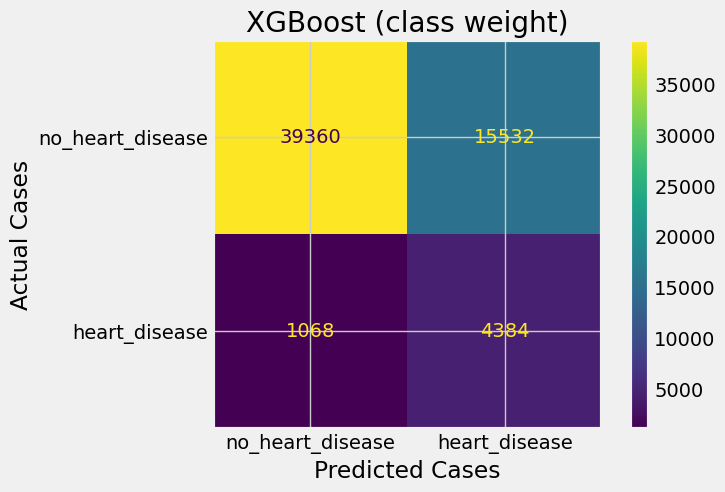

In [30]:
plot_cf_matrix(y_pred, y_val, 'XGBoost (class weight)')

## Notes
* Tuning Logist Regression did not improve the model.
* Tuning XGBoost lead to a small increase in recall.

In [31]:
feature_names = list(dv.get_feature_names_out())

In [32]:
def plot_feature_importances(model, df, title, feature_names, plt):
    n_features = df.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), feature_names)
    plt.tick_params(labelsize='small')
    plt.xlabel("Feature importance", labelpad=20)
    plt.ylabel("Feature", labelpad=20)
    plt.title(title)

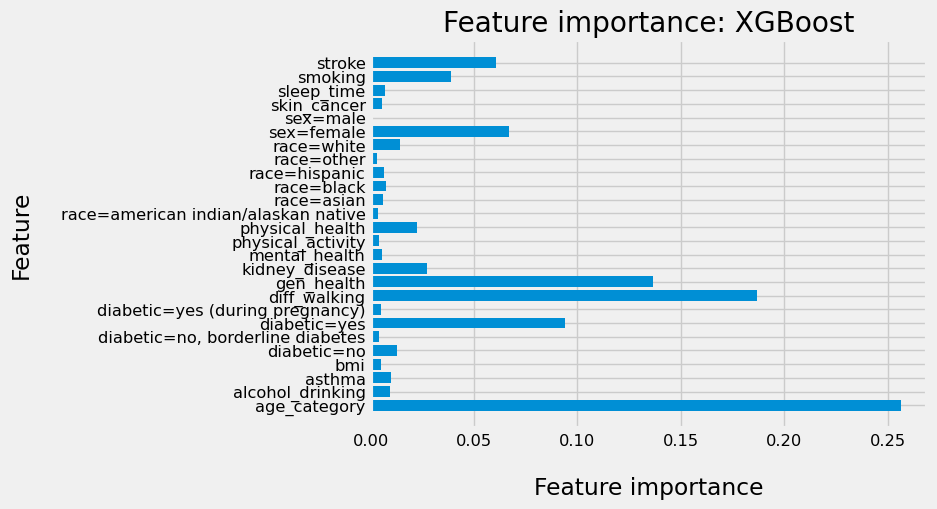

In [33]:
plot_feature_importances(model_xgb, X_train_dv, 'Feature importance: XGBoost', feature_names, plt)

In [34]:
test_dict = X_test[features].to_dict(orient='records')

# encode dictionary of features
X_test_dv = dv.transform(test_dict)

In [35]:
y_pred = model_xgb.predict(X_test_dv)

get_metrics(y_pred, y_test)

-------------------------
         METRICS         
-------------------------
Accuracy       =   0.7263
F1 Score       =   0.3459
MCC            =   0.3174
Precision      =   0.2205
Recall         =   0.801 
ROC/AUC        =   0.7599
Specificity    =   0.7188
-.-.-.-.-.-.-.-.-.-.-.-.


# BentoML

In [36]:
import bentoml

In [38]:
# save the model
bentoml.xgboost.save_model(
    'heart_disease_model',
    model_xgb,
    custom_objects={
        'dictVectorizer': dv
    })

Model(tag="heart_disease_model:cwhjxjsys2beufhw", path="/home/smv/bentoml/models/heart_disease_model/cwhjxjsys2beufhw/")

## Test

In [39]:
import json

In [40]:
request = X_test.iloc[0].to_dict()
print(json.dumps(request, indent=2))

{
  "bmi": 25.86,
  "smoking": 1,
  "alcohol_drinking": 0,
  "stroke": 0,
  "physical_health": 0,
  "mental_health": 0,
  "diff_walking": 0,
  "sex": "female",
  "age_category": 11,
  "race": "white",
  "diabetic": "no",
  "physical_activity": 1,
  "gen_health": 3,
  "sleep_time": 7,
  "asthma": 1,
  "kidney_disease": 0,
  "skin_cancer": 0
}


In [45]:
request = X_test.iloc[10].to_dict()
print(json.dumps(request, indent=2))

{
  "bmi": 23.63,
  "smoking": 1,
  "alcohol_drinking": 0,
  "stroke": 1,
  "physical_health": 0,
  "mental_health": 15,
  "diff_walking": 0,
  "sex": "female",
  "age_category": 11,
  "race": "other",
  "diabetic": "no",
  "physical_activity": 1,
  "gen_health": 3,
  "sleep_time": 8,
  "asthma": 0,
  "kidney_disease": 1,
  "skin_cancer": 1
}
